In [46]:
#track top left corner of the DL mask and see how it rotates
#revert the DL crop back to the original DL mask (size, orientation...)
#1.rotate DL mask
#we want to paste the crop back on the dl mask
#

In [48]:
#cv2 bitwise_or
#only works on images with the same dimension, it overlaps the images

# paste image by centroid
# might need the mask again.
# we can try to calculate the difference between the new centroid and the original centroid

In [49]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

In [50]:
def rotate_image_cv2(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

In [56]:
src = r"\\fatherserverdw\kyuex\clue images\1um"
dst = os.path.join(src, 'classification_v9_combined\crop_TA\crop_HE_DL')

In [57]:

degrot_LUT = pd.read_csv(r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\new_CLUEdegrot.csv")

In [58]:
degrot_LUT

,Unnamed: 0.1,Unnamed: 0,imID,imname,secN,k,degrot,centroid
0,0,0,0,2022-06-07 14.27.44,1,[ 0.33982065 0.94049026 -0.94049026 0.33982065],160.13,"(9319.690124103598, 8086.429334669696)"
1,1,1,1,2022-06-07 14.32.24,1,[-0.13191004 -0.99126169 0.99126169 -0.13191004],352.42,"(14333.236200958356, 5900.067819168355)"
2,2,2,2,2022-06-07 14.34.59,1,[ 0.31836081 0.94796962 -0.94796962 0.31836081],161.44,"(9890.519811487757, 5622.40267381882)"
3,3,3,3,2022-06-07 14.37.19,1,[-0.53153658 -0.84703534 0.84703534 -0.53153658],327.89,"(8653.761477488122, 4747.436996898308)"
4,4,4,4,2022-06-07 16.13.52,1,[ 0.38013247 0.92493205 0.92493205 -0.38013247],22.34,"(11372.527128647533, 5030.097351796957)"
5,5,5,4,2022-06-07 16.13.52,2,[ 0.4366632 0.89962506 0.89962506 -0.4366632 ],25.89,"(25698.40520889134, 6008.134870711241)"
6,6,6,4,2022-06-07 16.13.52,3,[ 0.38595748 0.92251657 0.92251657 -0.38595748],22.70,"(9569.144164100746, 12781.550714150342)"
7,7,7,4,2022-06-07 16.13.52,4,[-0.25799689 -0.96614575 -0.96614575 0.25799689],194.95,"(25412.454828099595, 14437.731346141207)"
8,8,8,5,2022-06-07 17.24.15,1,[ 0.44819642 0.8939351 0.8939351 -0.44819642],26.63,"(12316.50920598856, 4217.289909522457)"
9,9,9,5,2022-06-07 17.24.15,2,[ 0.48687151 0.8734736 0.8734736 -0.48687151],29.14,"(6811.3017028114955, 10162.077581167496)"


In [59]:
LUT = degrot_LUT.iloc[0]

imname = LUT['imname']
imID = LUT['imID']
degrot =  LUT['degrot']
sec = LUT['secN']
cent = LUT['centroid']


In [60]:


mask_path = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\{}.tif".format(imname)
mask = Image.open(mask_path)
im_path =  r"\\fatherserverdw\kyuex\clue images\1um\{}.tif".format(imname)
im = Image.open(im_path)

In [61]:
DLcrop_pth = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\mask\{}.png".format(imname + '_sec01')
DLcrop = Image.open(DLcrop_pth)

In [62]:
#size of original whole-slide image
(w,h) = im.size


In [63]:
#create blank image
imgblank  = np.full((h, w), 235 ) #235 is background value

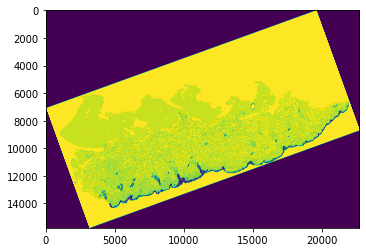

In [65]:
#rotate crop back to original orientation?

im_rot = rotate_image_cv2(np.array(DLcrop), -degrot)
plt.imshow(im_rot)



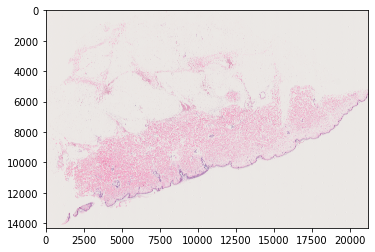

In [66]:
plt.imshow(im)